<h1 align='center'> CE1015 Project - FE2 Group 9 </h1>

### Presented by
Brandon
<br>Kenny
<br>Sabrina
<br>Sneha




## Import Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold


In [2]:
listings = pd.read_csv("listings.csv")
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [3]:
calendar = pd.read_csv("calendar.csv")
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


<h1 align='center'> Data Cleaning  </h1>


### Drop the colums that is useless and missing a lot of data

In [4]:
listings.isna().sum().sort_values(ascending = False).head(15)

license                   3818
square_feet               3721
monthly_price             2301
security_deposit          1952
weekly_price              1809
notes                     1606
neighborhood_overview     1032
cleaning_fee              1030
transit                    934
host_about                 859
host_acceptance_rate       773
review_scores_accuracy     658
review_scores_checkin      658
review_scores_value        656
review_scores_location     655
dtype: int64

In [5]:
listings = pd.read_csv("https://raw.githubusercontent.com/brandonywl/cz1015-miniproject/master/listings.csv")
variables = [var for var in listings]


variables_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',\
                     'host_url', 'host_name', 'host_id', 'host_since', 'host_location', 'host_about', 'host_response_time', 'name',\
                     'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit']

variables_to_drop += ["host_acceptance_rate", "host_is_superhost", "country", "country_code", "smart_location", "state", "city", \
                      "host_thumbnail_url", "host_picture_url", "host_verifications", "host_has_profile_pic", "host_identity_verified",\
                      "neighbourhood_cleansed", "neighbourhood", "market", 'host_neighbourhood', 'host_response_rate', 'host_listings_count', \
                      'host_total_listings_count', 'street']

variables_to_drop += ["is_location_exact", "bed_type", "extra_people", "minimum_nights", "maximum_nights", \
                      "calendar_updated", 'has_availability']

variables_to_drop += ["calendar_last_scraped", "first_review", "last_review","jurisdiction_names", "requires_license", "license", \
                      "availability_60", "availability_90"]

variables_to_drop += ["square_feet"]


for var in variables_to_drop:
    try:
      variables.remove(var)
    except:
      pass

listings = pd.DataFrame(listings[variables])

listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
id                                  3818 non-null int64
neighbourhood_group_cleansed        3818 non-null object
zipcode                             3811 non-null object
latitude                            3818 non-null float64
longitude                           3818 non-null float64
property_type                       3817 non-null object
room_type                           3818 non-null object
accommodates                        3818 non-null int64
bathrooms                           3802 non-null float64
bedrooms                            3812 non-null float64
beds                                3817 non-null float64
amenities                           3818 non-null object
price                               3818 non-null object
weekly_price                        2009 non-null object
monthly_price                       1517 non-null object
security_deposit                   

In [6]:
listings.isna().sum().sort_values(ascending = False).head(15)

monthly_price                  2301
security_deposit               1952
weekly_price                   1809
cleaning_fee                   1030
review_scores_accuracy          658
review_scores_checkin           658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
reviews_per_month               627
bathrooms                        16
zipcode                           7
bedrooms                          6
dtype: int64

### Numerical related variable

In [7]:
cleaned_data = listings.copy()

# Convert the price, weekly price and monthly price from string to float 
prices = ["price", "weekly_price", "monthly_price", "security_deposit", "cleaning_fee"]
for price in prices:
  cleaned_data[price] = cleaned_data[price].str.replace("$","")
  cleaned_data[price] = cleaned_data[price].str.replace(",","")
  cleaned_data[price] = cleaned_data[price].astype("float64")

# Assuming no entry means no reviews
cleaned_data["reviews_per_month"].fillna(value = 0, inplace = True)

# Isolate all the review_scores and fill in empty reviews with the median, assuming that no review means people deem it to be normal
review_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_communication', \
                 'review_scores_location', 'review_scores_value']

for review in review_scores:
  cleaned_data[review].fillna(value = cleaned_data[review].median(), inplace = True)

# Assume that empty entries == no special price. Hence weekly price = price * 7 and monthly price = price * 31
empty_prices = ["weekly_price", "monthly_price"]
days = [7,31]
count = 0
for price in empty_prices:
  cleaned_data[price].fillna(value = cleaned_data['price'] * days[count], inplace = True)
  count += 1

# Assume that empty entries == No security deposit and no cleaning fees
empty_prices = ['security_deposit', 'cleaning_fee']
for price in empty_prices:
  cleaned_data[price].fillna(value = 0, inplace = True)

# As some accomodations have 4.5 toilets, we are going to assume that an empty entry == there are no toilets in the apartment. Same goes for
# beds and bedrooms
# This can be the scenario where they only rent the apartment, hence no access to the toilet
# Or they rent a boat and does not count as a bedroom / bed
rooms = ['bathrooms', 'bedrooms', 'beds']
for room in rooms:
  cleaned_data[room].fillna(value = 0, inplace = True)


# We will be classifying the only entry with no property_type under 'Other'
cleaned_data['property_type'].fillna(value = 'Other', inplace = True)


# Isolate all the categorical data as they are the only ones with type object
categorical_data = ['instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', \
                    'require_guest_phone_verification', 'neighbourhood_group_cleansed', \
                    'property_type', 'room_type']
for data in categorical_data:
  # Convert data type to category
  cleaned_data[data] = cleaned_data[data].astype('category')



cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
id                                  3818 non-null int64
neighbourhood_group_cleansed        3818 non-null category
zipcode                             3811 non-null object
latitude                            3818 non-null float64
longitude                           3818 non-null float64
property_type                       3818 non-null category
room_type                           3818 non-null category
accommodates                        3818 non-null int64
bathrooms                           3818 non-null float64
bedrooms                            3818 non-null float64
beds                                3818 non-null float64
amenities                           3818 non-null object
price                               3818 non-null float64
weekly_price                        3818 non-null float64
monthly_price                       3818 non-null float64
security_deposit          

### Property Type

In [8]:
cleaned_data.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                23
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

In [9]:
# Replacing categories that are types of houses or apartments
cleaned_data.property_type.replace({
    'Townhouse': 'House',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
cleaned_data.loc[~cleaned_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
cleaned_data.property_type.value_counts()

House        1866
Apartment    1748
Other         204
Name: property_type, dtype: int64

### Amenenities

In [10]:
# change the object to str
amenities=cleaned_data["amenities"].astype("str")
#join the data by "," and split the long string into a wordlist by ","
amenities=','.join(amenities)
word_list=amenities.split(sep=",")

new_wordlist=[]
#clean the data
for word in word_list:
    word=word.replace("}","")
    word=word.replace("{","")
    word=word.replace("\"","")
    new_wordlist.append(word)
    
#convert to a series and count the unique amenities
word_series=pd.Series(new_wordlist)
len(word_series.unique())


42

In [11]:
word_series.value_counts()

Wireless Internet             3667
Heating                       3627
Kitchen                       3423
Smoke Detector                3281
Essentials                    3237
Dryer                         2997
Washer                        2992
Internet                      2811
Shampoo                       2670
TV                            2574
Carbon Monoxide Detector      2485
Fire Extinguisher             2196
Free Parking on Premises      2167
Family/Kid Friendly           1963
First Aid Kit                 1680
Cable TV                      1446
Indoor Fireplace               886
Pets live on this property     883
Hangers                        846
Elevator in Building           785
Hair Dryer                     774
Laptop Friendly Workspace      745
Iron                           742
Safety Card                    727
Air Conditioning               677
24-Hour Check-in               616
Buzzer/Wireless Intercom       538
Dog(s)                         509
Pets Allowed        

### Choosing the amenitites that might be useful to determine the price
I'll ignore amenities that is over 3000 because most of the listing have it. Also, the amenities that contain less than 400

Dryer/ washer 

TV / Cable TV

Free_Parking on Premises

Family/Kid Friendly

Pets live on this property /Pets Allowed /Dog(s) / Cat(s)

Elevator in Building

Safety Card 

Air Conditioning

24-Hour Check-in

Gym

In [12]:
cleaned_data.loc[cleaned_data['amenities'].str.contains('Dryer|Washer'), 'Laundry'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('TV|"Cable TV'), 'TV'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Free Parking on Premises'), 'Parking'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Family/Kid Friendly'), 'Family_friendly'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Pets live on this property|Pets Allowed|Cat(s)|Dog(s)'), 'Pets_friendly'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Elevator in Building'), 'Elevator'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Safety Card'), 'Security'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Air Conditioning'), 'Air_conditioning'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('24-Hour Check-in'), '24-Hour_Check-in'] = 1
cleaned_data.loc[cleaned_data['amenities'].str.contains('Gym'), 'Gym'] = 1


C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [13]:
# Replacing nulls with zeros for new columns
amenities_cols = ["Laundry","TV","Parking","Family_friendly","Pets_friendly","Elevator","Security","Air_conditioning","24-Hour_Check-in","Gym"]
cleaned_data[amenities_cols] = cleaned_data[amenities_cols].fillna(0)

# Dropping amenities
cleaned_data.drop('amenities', axis=1, inplace=True)


In [14]:
cleaned_data[amenities_cols]

,Laundry,TV,Parking,Family_friendly,Pets_friendly,Elevator,Security,Air_conditioning,24-Hour_Check-in,Gym
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3813,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3814,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3815,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3816,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h1 align='center'> Exploratory Analysis  </h1>


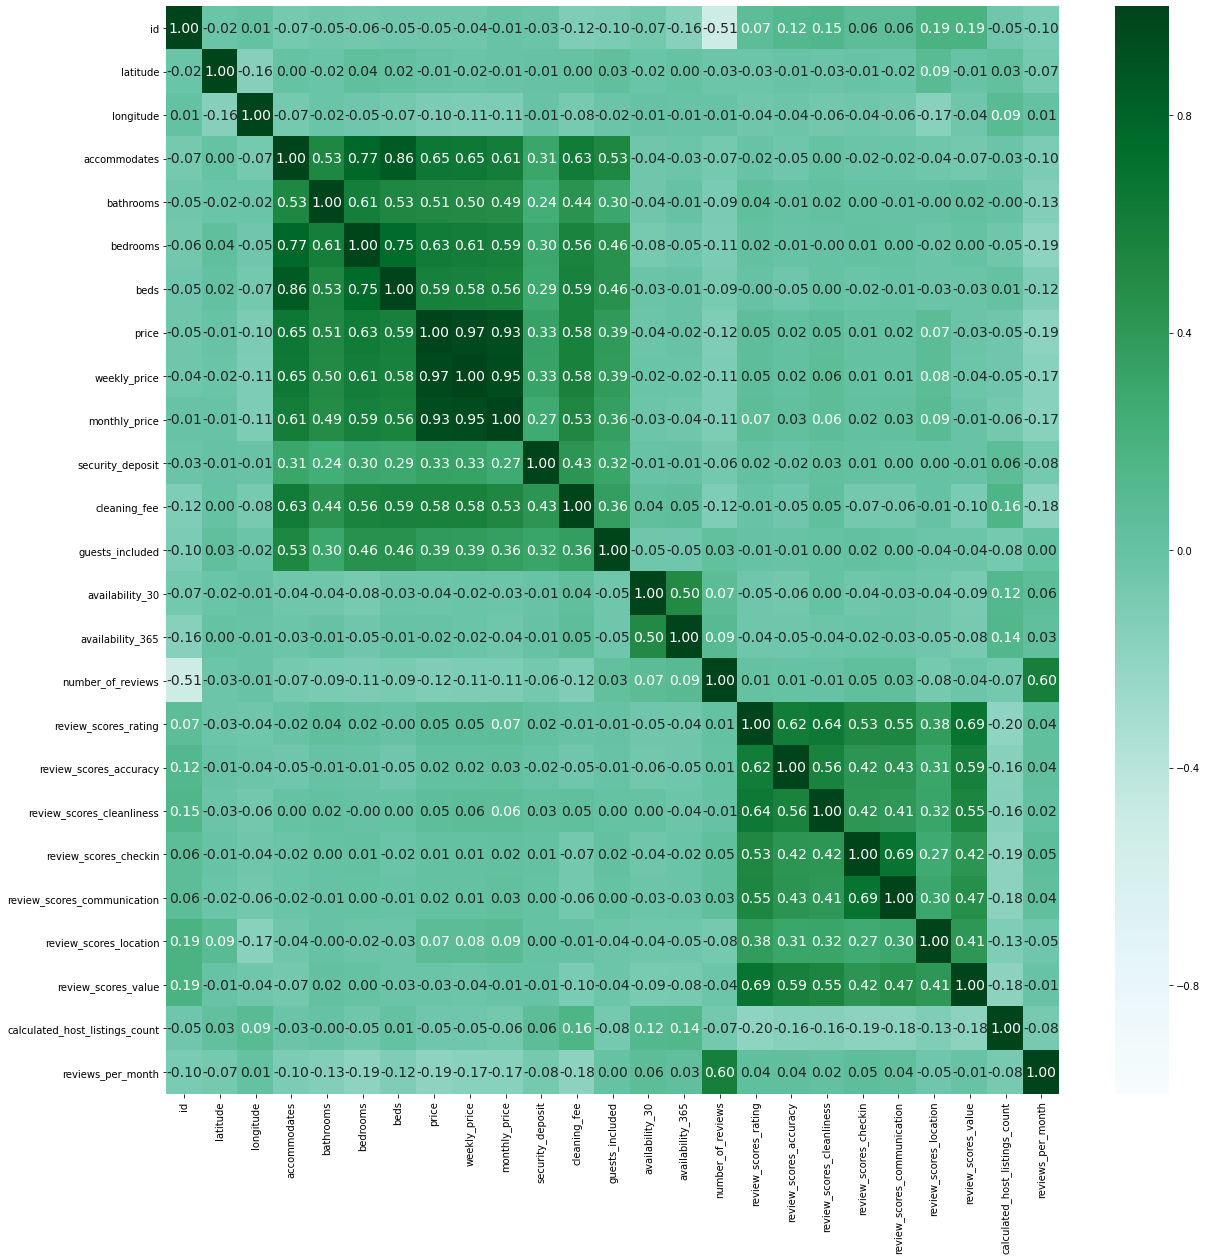

In [15]:
f, axes = plt.subplots(1,1, figsize = (20,20))
sb.heatmap(cleaned_data.drop(amenities_cols,axis=1).corr(),annot = True, fmt = ".2f", annot_kws = {"size": 14},
           vmin = -1, vmax = 1, cmap = 'BuGn')

 ### How does number of accomodates affect the price?

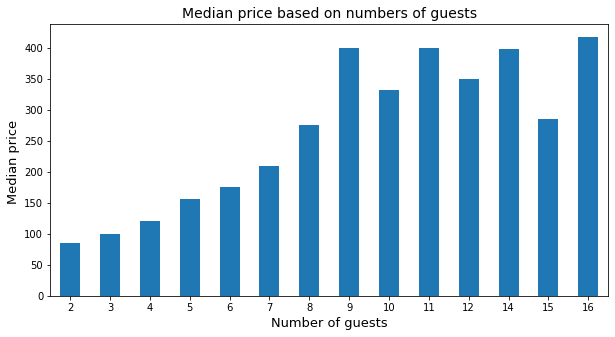

In [16]:
plt.figure(figsize=(10,5))
cleaned_data.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price based on numbers of guests', fontsize=14)
plt.xlabel('Number of guests', fontsize=13)
plt.ylabel('Median price ', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

### How neigbourhood affect the price?

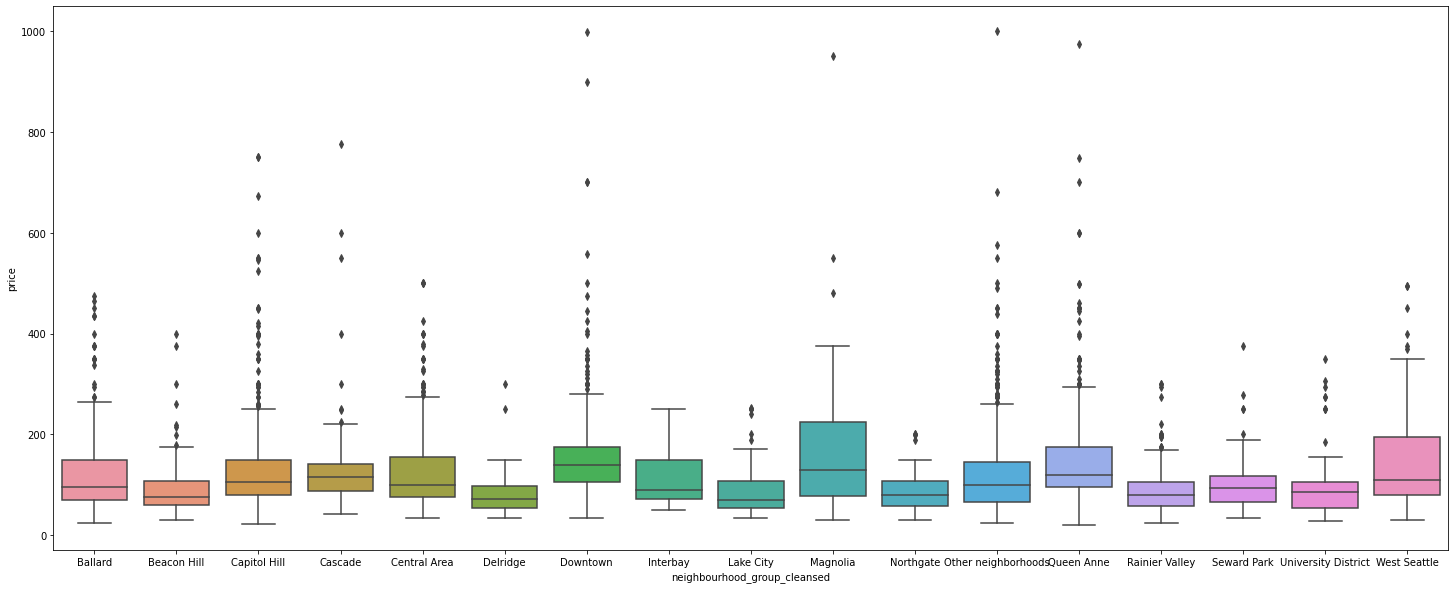

In [17]:
plt.figure(figsize=(25,10))
# visualise it in boxplot
sb.boxplot(x=cleaned_data.neighbourhood_group_cleansed,y=cleaned_data.price)

In [18]:
#get the mean of the neighbourhood_group_cleansed
cleaned_data.groupby('neighbourhood_group_cleansed').size()

neigh_group = pd.DataFrame(cleaned_data.groupby('neighbourhood_group_cleansed').size())
neigh_group.rename(columns={0: 'number_of_listings'}, inplace=True)
neigh_group['median_price'] = cleaned_data.groupby('neighbourhood_group_cleansed').price.median().values

In [19]:
neigh_group['median_price'].sort_values(ascending = False)

neighbourhood_group_cleansed
Downtown               139.0
Magnolia               129.0
Queen Anne             119.0
Cascade                115.0
West Seattle           109.0
Capitol Hill           105.0
Central Area           100.0
Other neighborhoods     99.0
Ballard                 95.0
Seward Park             93.0
Interbay                90.0
University District     85.0
Rainier Valley          80.0
Northgate               79.5
Beacon Hill             75.0
Delridge                72.0
Lake City               70.0
Name: median_price, dtype: float64

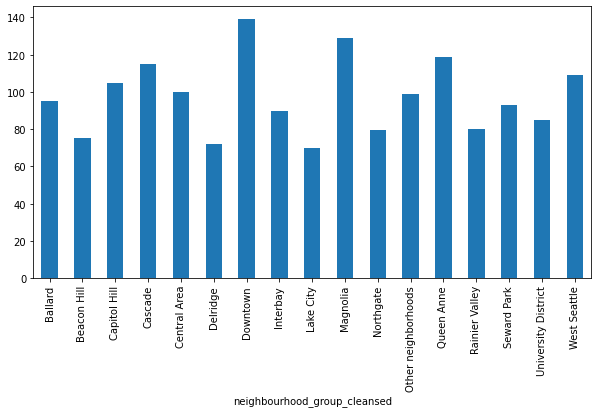

In [20]:
plt.figure(figsize=(10,5))
cleaned_data.groupby('neighbourhood_group_cleansed').price.median().plot(kind="bar")
plt.show()

In [21]:
neigh_group.index

CategoricalIndex(['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade',
                  'Central Area', 'Delridge', 'Downtown', 'Interbay',
                  'Lake City', 'Magnolia', 'Northgate', 'Other neighborhoods',
                  'Queen Anne', 'Rainier Valley', 'Seward Park',
                  'University District', 'West Seattle'],
                 categories=['Ballard', 'Beacon Hill', 'Capitol Hill', 'Cascade', 'Central Area', 'Delridge', 'Downtown', 'Interbay', ...], ordered=False, name='neighbourhood_group_cleansed', dtype='category')

In [23]:
import geopandas as gpd
import adjustText as aT

map_df = gpd.read_file('neighborhoods.geojson')
len(map_df.nhood.unique())

85

In [24]:
map_diff = map_df[map_df['nhood'].isin(neigh_group.index)]

In [25]:
len(map_diff.nhood.unique())

16

In [26]:
seatle_map_df = map_diff.set_index('nhood').join(neigh_group)


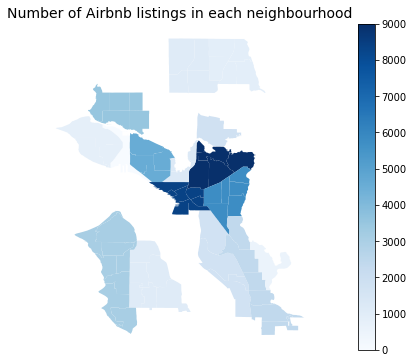

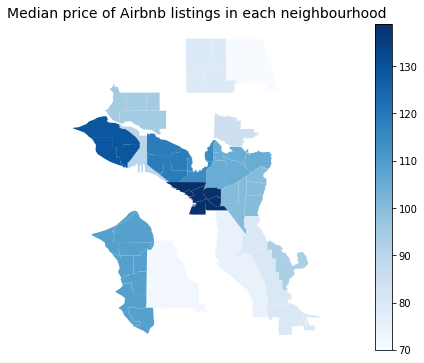

In [27]:
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1,figsize=(15, 6))
seatle_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
seatle_map_df.plot(markersize=14,column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(seatle_map_df.median_price), vmax=max(seatle_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)



plt.show()

## How amenitites affect Price

In [28]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    cleaned_data.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    cleaned_data.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price')
    ax2.set_xlabel('')
    
    plt.show()

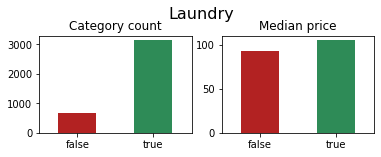

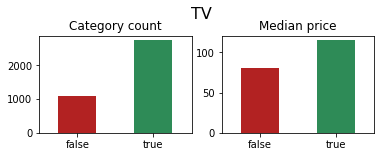

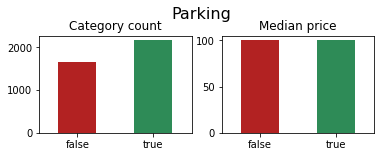

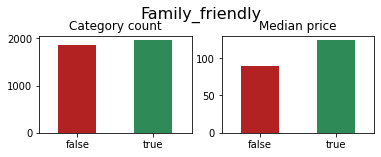

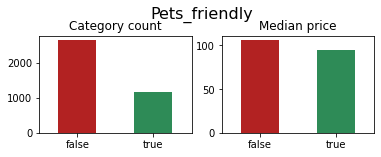

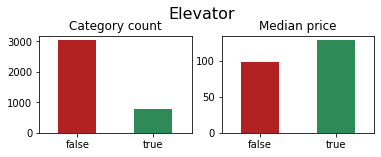

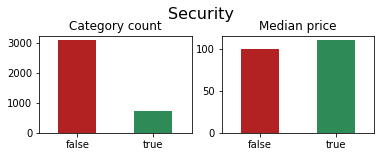

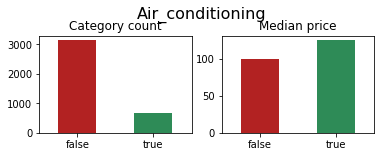

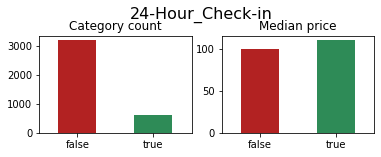

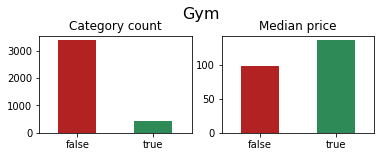

In [29]:
for col in cleaned_data[amenities_cols]:
    binary_count_and_price_plot(col, figsize=(6,2))

<h1 align='center'> Data preparing for Linear regression  </h1>


In [30]:
cleaned_data.columns

Index(['id', 'neighbourhood_group_cleansed', 'zipcode', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'availability_30', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month', 'Laundry', 'TV',
       'Parking', 'Family_friendly', 'Pets_friendly', 'Elevator', 'Security',
       'Air_conditioning', '24-Hour_Check-in', 'Gym'],
      dtype='object')

In [31]:
regression_variables = ['price',"guests_included", 'neighbourhood_group_cleansed', 'property_type', 'room_type','security_deposit', 'cleaning_fee', 'accommodates', 'bathrooms', 'bedrooms', 'beds']
amenities_cols = ["Laundry","TV","Parking","Family_friendly","Pets_friendly","Elevator","Security","Air_conditioning","24-Hour_Check-in","Gym"]

regression_data = cleaned_data[regression_variables+amenities_cols]

regression_data

,price,guests_included,neighbourhood_group_cleansed,property_type,room_type,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,...,Laundry,TV,Parking,Family_friendly,Pets_friendly,Elevator,Security,Air_conditioning,24-Hour_Check-in,Gym
0,85.0,2,Queen Anne,Apartment,Entire home/apt,0.0,0.0,4,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,150.0,1,Queen Anne,Apartment,Entire home/apt,100.0,40.0,4,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,975.0,10,Queen Anne,House,Entire home/apt,1000.0,300.0,11,4.5,5.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,100.0,1,Queen Anne,Apartment,Entire home/apt,0.0,0.0,3,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,450.0,6,Queen Anne,House,Entire home/apt,700.0,125.0,6,2.0,3.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,359.0,1,Other neighborhoods,House,Entire home/apt,0.0,230.0,6,2.0,3.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3814,79.0,3,Capitol Hill,Apartment,Entire home/apt,500.0,50.0,4,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3815,93.0,2,Rainier Valley,House,Entire home/apt,250.0,35.0,2,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3816,99.0,1,Capitol Hill,Other,Entire home/apt,300.0,45.0,2,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
transformed_df = pd.get_dummies(regression_data)
transformed_df

,price,guests_included,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,Laundry,TV,...,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,85.0,2,0.0,0.0,4,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
1,150.0,1,100.0,40.0,4,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
2,975.0,10,1000.0,300.0,11,4.5,5.0,7.0,1.0,1.0,...,0,0,0,0,0,1,0,1,0,0
3,100.0,1,0.0,0.0,3,1.0,0.0,2.0,1.0,0.0,...,0,0,0,0,1,0,0,1,0,0
4,450.0,6,700.0,125.0,6,2.0,3.0,3.0,0.0,1.0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,359.0,1,0.0,230.0,6,2.0,3.0,3.0,1.0,1.0,...,0,0,0,0,0,1,0,1,0,0
3814,79.0,3,500.0,50.0,4,1.0,1.0,2.0,1.0,1.0,...,0,0,0,0,1,0,0,1,0,0
3815,93.0,2,250.0,35.0,2,1.0,1.0,1.0,1.0,1.0,...,1,0,0,0,0,1,0,1,0,0
3816,99.0,1,300.0,45.0,2,1.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,1,0,0


### Standardising and normalising



In [33]:

numerical_columns = ['accommodates', 'bathrooms', "bedrooms","beds","guests_included",'cleaning_fee', 'price', 'security_deposit']

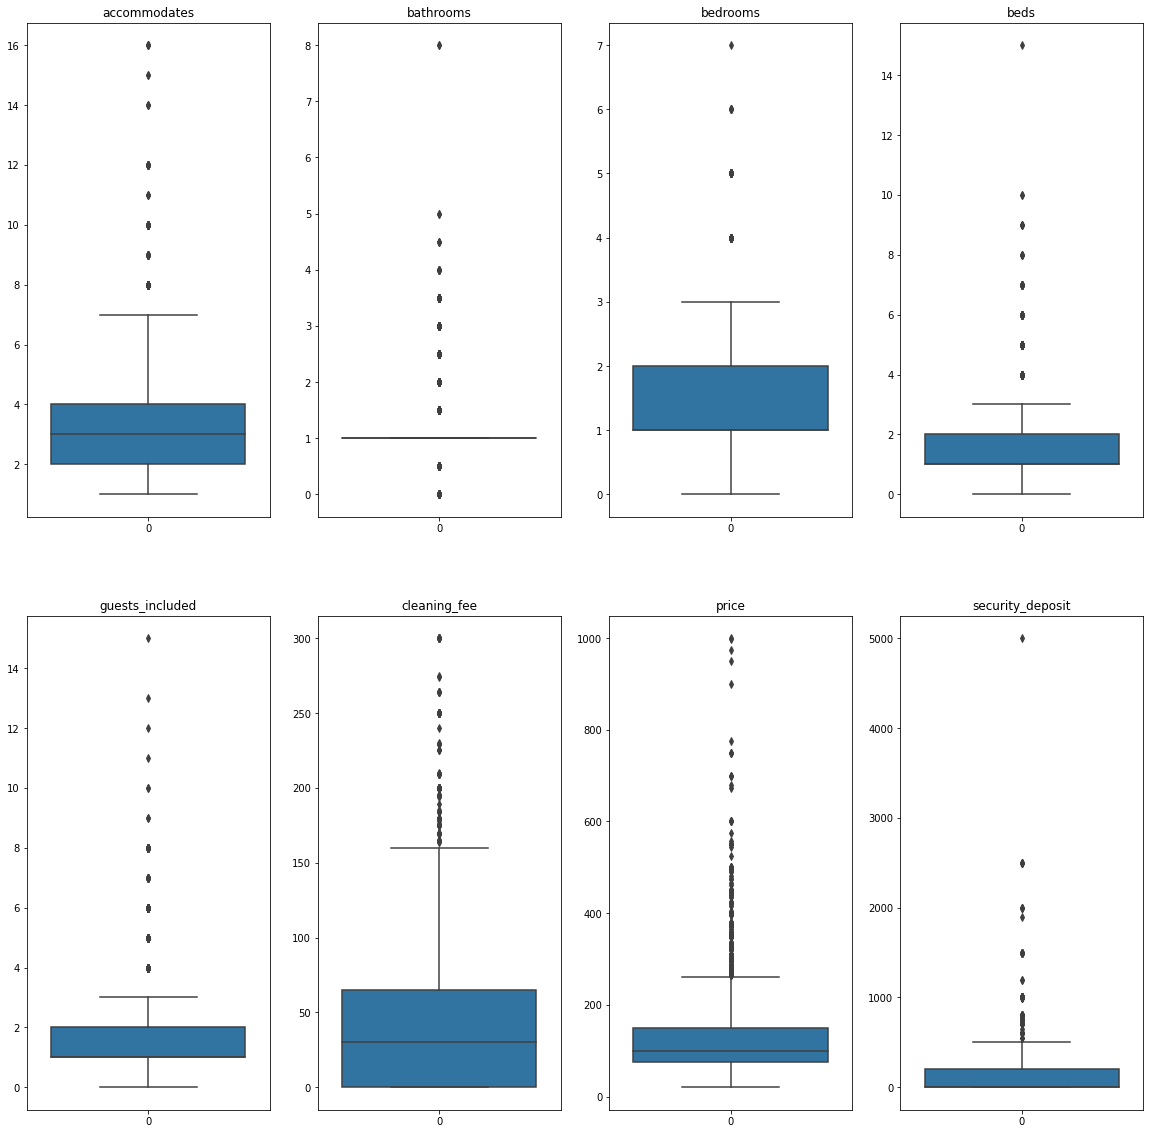

In [34]:
f,axes=plt.subplots(2,4,figsize=(20,20))
r=0
c=0
for am in numerical_columns:
    axes[r][c].set_title(am)
    sb.boxplot(data=transformed_df[am], ax=axes[r][c])
    c+=1
    if(c==4): 
        r=1 
        c=0


C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\plottin

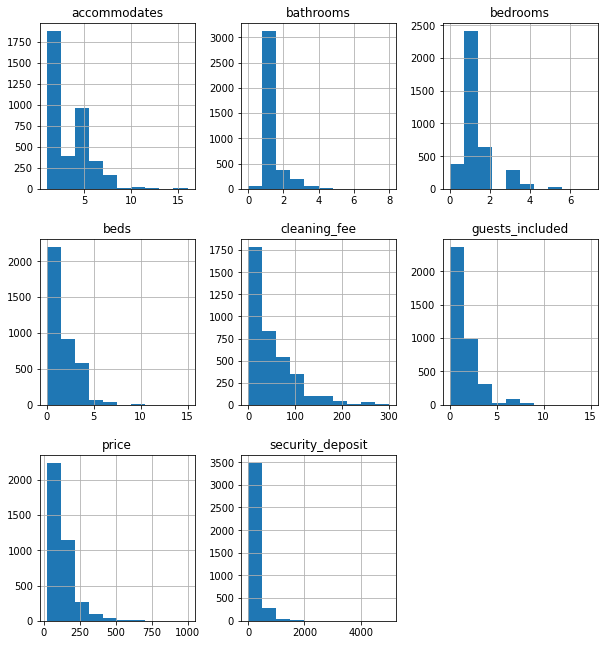

In [35]:
transformed_df[numerical_columns].hist(figsize=(10,11));


In [36]:
# Log transforming columns
#numerical_columns = [i for i in numerical_columns ] # Removing items not to be transformed
#numerical_columns=["price"]
for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64')
    transformed_df[col] = np.log(transformed_df[col]+1)
def normalize(column):
    upper=column.max()
    lower=column.min()
    y=(column-lower)/(upper-lower)
    return y
#normalize(transformed_df[numerical_columns])

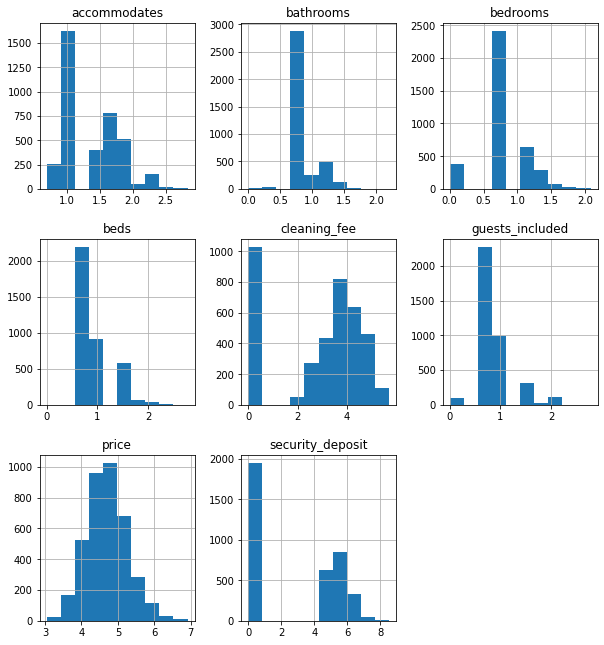

In [37]:
transformed_df[numerical_columns].hist(figsize=(10,11));
# Scaling


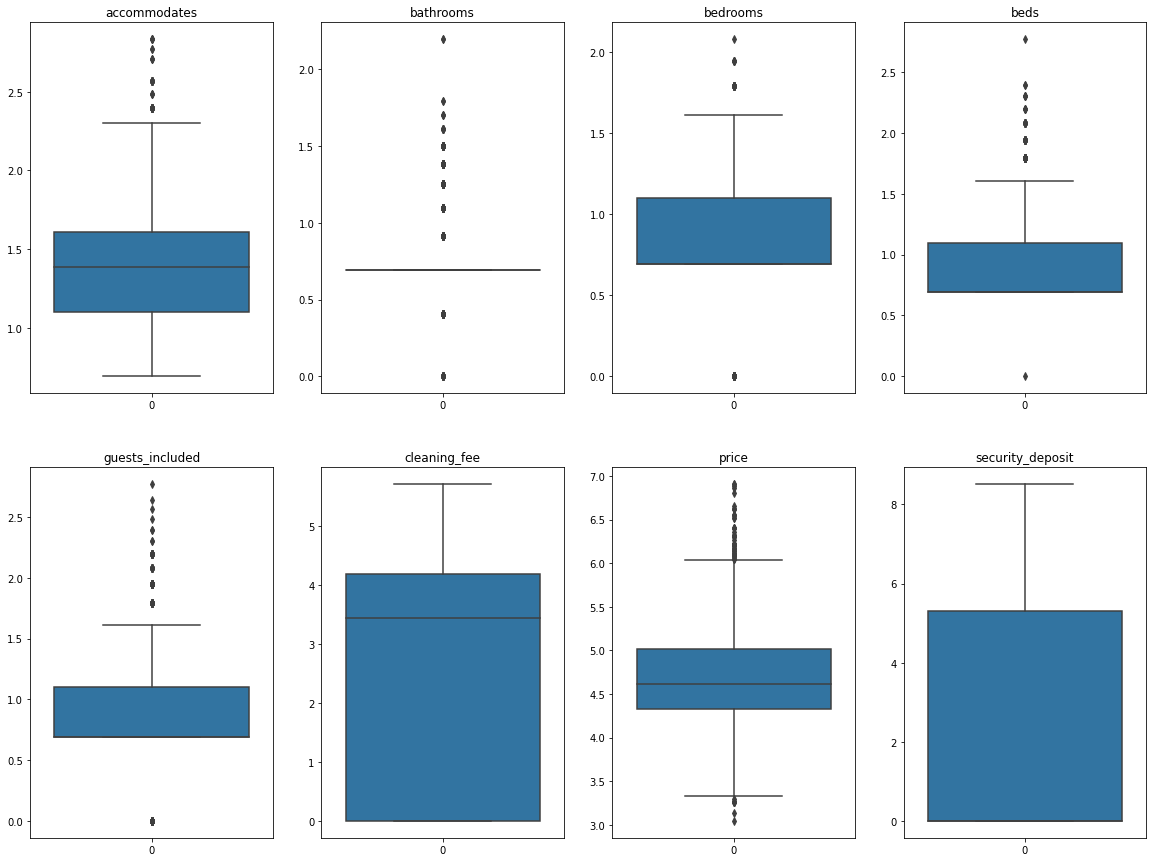

In [38]:
f,axes=plt.subplots(2,4,figsize=(20,15))
r=0
c=0
for am in numerical_columns:
    axes[r][c].set_title(am)
    sb.boxplot(data=transformed_df[am], ax=axes[r][c])
    c+=1
    if(c==4): 
        r=1 
        c=0


<h1 align='center'> Problem1 : dawdawdwa  </h1>


# Split into test train set

In [39]:

# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
#pd.DataFrame(X, columns=list(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [40]:
transformed_df.to_csv("linear_regression_data.csv")

# Various Linear regression Algorithm

## Ordinary least squares Linear Regression.

Intercept of Regression 	: b =  4.6890262401337095
Coefficients of Regression 	: a =  [ 1.53104722e-02  6.44157022e-03  4.30073202e-03  1.32218768e-01
  6.93080028e-02  1.19782999e-01  9.74449627e-03 -6.57460471e-03
  1.40006315e-02 -2.77620435e-03 -6.25708519e-03 -1.90509742e-03
  2.33370732e-02  1.52675312e-02  1.10050496e-02 -3.88340261e-02
  6.26854642e-03  8.24402354e+09  5.99640494e+09  1.23210892e+10
  5.22805663e+09  1.02378525e+10  4.93219645e+09  1.19798927e+10
  1.85710675e+09  4.54946178e+09  4.34444800e+09  4.96265095e+09
  1.40621016e+10  9.25159084e+09  6.92195633e+09  3.69808061e+09
  6.09389525e+09  7.77412031e+09  2.34045592e+10  2.34822823e+10
  1.05646165e+10  6.72387370e+10  6.55432918e+10  2.45625946e+10]



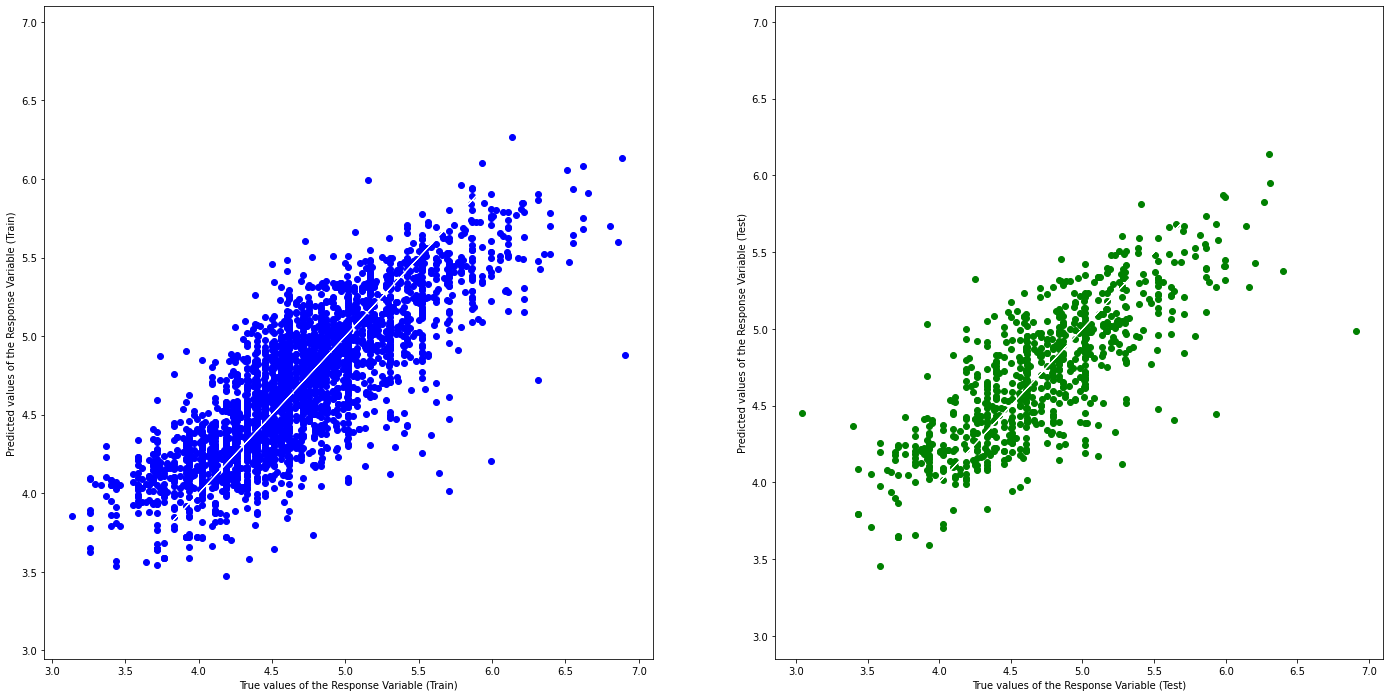

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6649613403136219
Mean Squared Error (MSE) 	: 0.10625337251561112

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6145572502178847
Mean Squared Error (MSE) 	: 0.11514078127371541


In [41]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()


# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))


## XGBRegressor
XGBoost stands for eXtreme Gradient Boosting
<br>XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data.
<br>The XGBoost library implements the gradient boosting decision tree algorithm.


C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



Training MSE: 0.0834
Validation MSE: 0.1064

Training r2: 0.737
Validation r2: 0.644


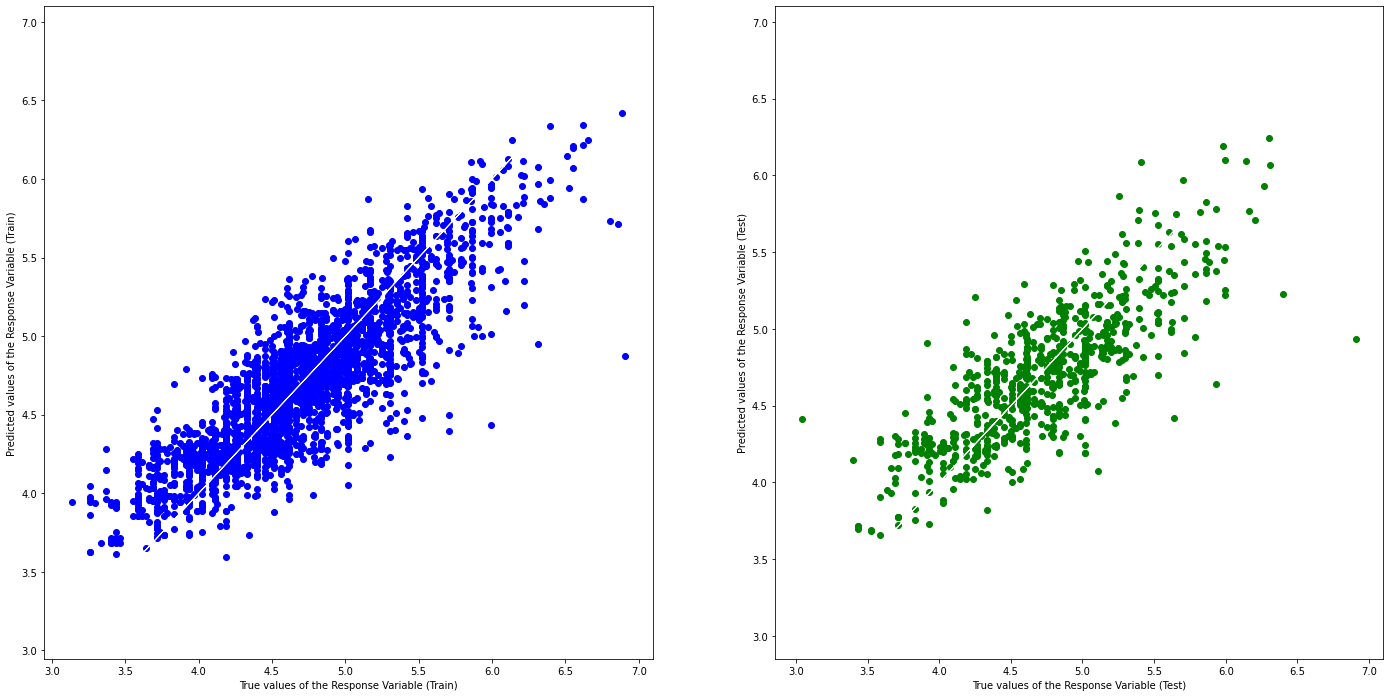

In [42]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

xgb_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)


print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, training_preds_xgb_reg, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, val_preds_xgb_reg, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [43]:
scores = cross_val_score(xgb_reg, X_train,y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean cross-validation score: 0.69


C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Brandon\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\B

K-fold CV average score: 0.69


In [44]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.head(20)

,weight
neighbourhood_group_cleansed_Interbay,0.000000
Gym,0.002054
property_type_Apartment,0.002081
neighbourhood_group_cleansed_Ballard,0.002770
Pets_friendly,0.002773
Laundry,0.002899
Family_friendly,0.003101
Parking,0.003259
beds,0.003566
neighbourhood_group_cleansed_Central Area,0.003605


In [45]:
ft_weights_xgb_reg.sort_values(ascending=False,by=["weight"]).head(10).index

Index(['bedrooms', 'room_type_Entire home/apt', 'accommodates', 'cleaning_fee',
       'bathrooms', 'room_type_Private room', 'Elevator',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Capitol Hill'],
      dtype='object')

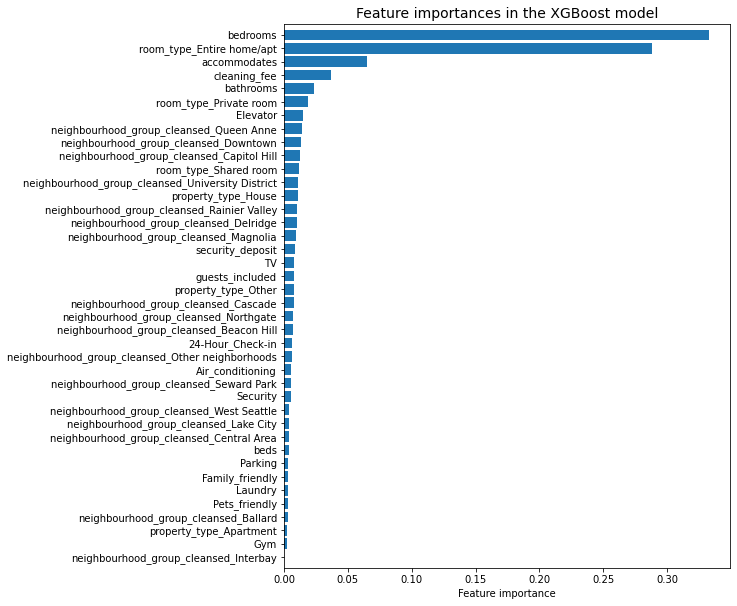

In [46]:
# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


## Random Forest
A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap Aggregation

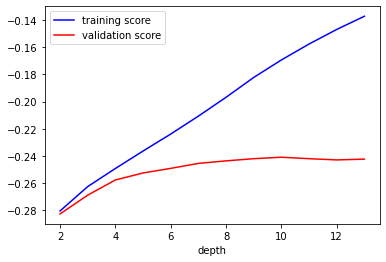

In [49]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100)
depth = [2, 3, 4,5,6,7,8,9,10,11,12,13]#try thisvariety of parameters for model
train_score, val_score = validation_curve(
 model, X_train, y_train,
 param_name='max_depth', param_range=depth, 
scoring='neg_mean_absolute_error', cv=3)
plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');


Training MSE: 0.0545
Validation MSE: 0.1033

Training r2: 0.8282
Validation r2: 0.6542


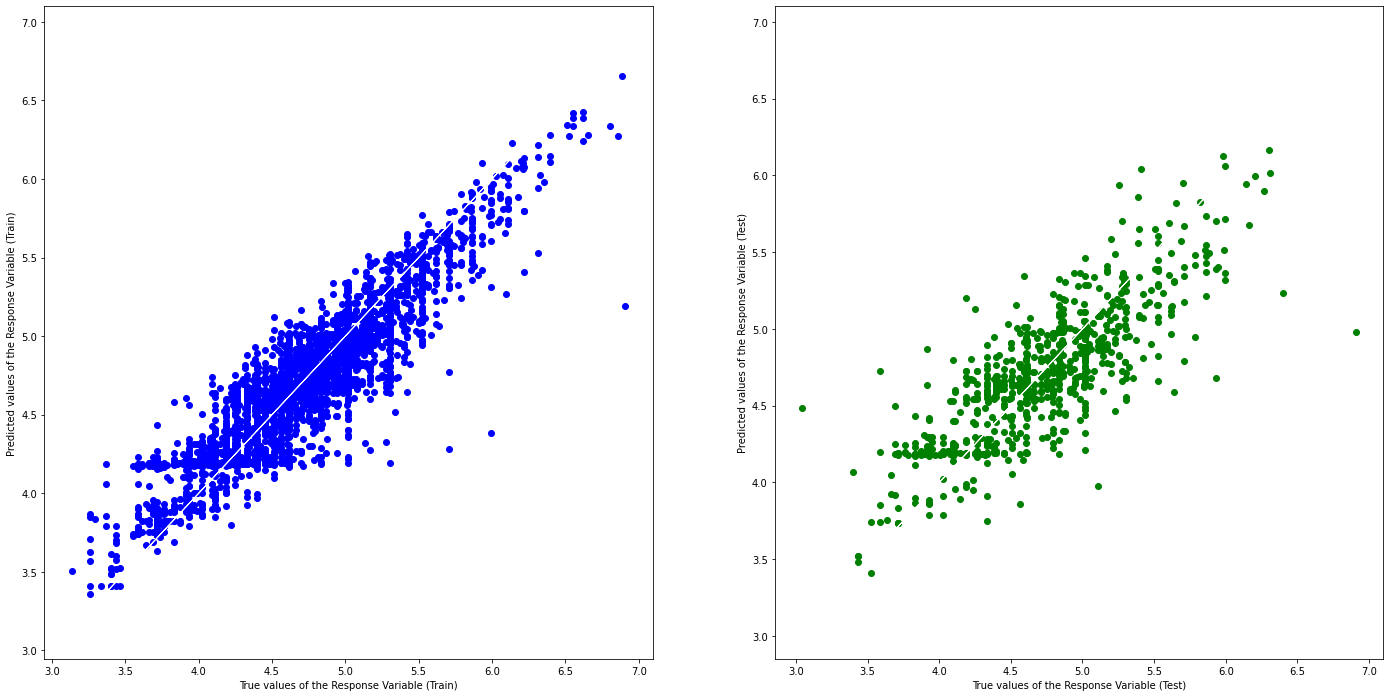

In [50]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500, 
                               max_depth=10,
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Neural Network using tensorflow 2.0
<br> We have done the test on the google collab 
<br> The following consist of the link to the collab

In [51]:
https://colab.research.google.com/drive/1S387BnwqN186zjZhi4wLhQS8MQoI487E

SyntaxError: invalid syntax (<ipython-input-51-c28be79ea66a>, line 1)

<h1 align='center'> Problem2 :  </h1>


In [52]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans

clustering_variables = ['id', 'price', 'cleaning_fee', \
                        'accommodates', 'bathrooms', \
                        'bedrooms', 'beds']
clustering_data = pd.DataFrame(cleaned_data[clustering_variables])
clustering_data.head()

,id,price,cleaning_fee,accommodates,bathrooms,bedrooms,beds
0,241032,85.0,0.0,4,1.0,1.0,1.0
1,953595,150.0,40.0,4,1.0,1.0,1.0
2,3308979,975.0,300.0,11,4.5,5.0,7.0
3,7421966,100.0,0.0,3,1.0,0.0,2.0
4,278830,450.0,125.0,6,2.0,3.0,3.0


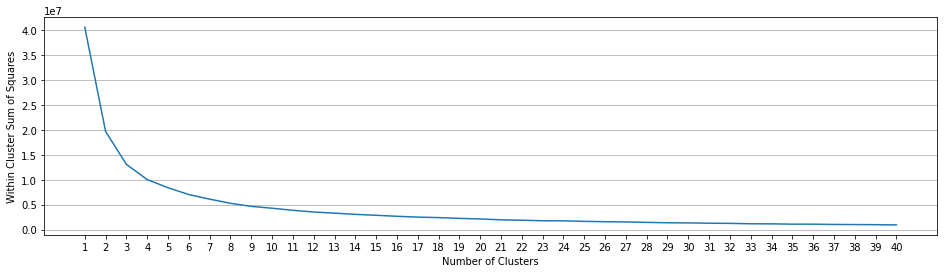

In [53]:
'''
Code obtained from M5 Clustering from Prof Sourav
'''

temp_clustering = clustering_data.iloc[:, 1:]
ids = pd.DataFrame(clustering_data.iloc[:, 0])

# Vary the Number of Clusters
min_clust = 1
max_clust = 40
init_algo = 'k-means++'

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust, init = init_algo, n_init = 5)
    kmeans.fit(temp_clustering)
    within_ss.append(kmeans.inertia_)

# Angle Plot : Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

In [54]:
# Set "optimal" Clustering Parameters
num_clust = 8
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(temp_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Features 	Price 	Fees 	Accom. 	WCs 	Rooms 	Beds

Cluster 0:	262.62	197.4	6.92	2.3	2.98	3.8	
Cluster 1:	69.31	10.97	2.17	1.11	0.93	1.19	
Cluster 2:	274.9	72.91	5.56	1.79	2.35	2.86	
Cluster 3:	164.56	99.76	4.85	1.42	1.84	2.49	
Cluster 4:	454.92	150.0	7.85	2.66	3.53	4.27	
Cluster 5:	152.53	20.98	3.32	1.17	1.23	1.62	
Cluster 6:	101.37	56.28	3.19	1.06	1.04	1.58	
Cluster 7:	807.14	167.36	8.43	2.79	3.5	4.5	

Within Cluster Sum of Squares : 5269221.541755871



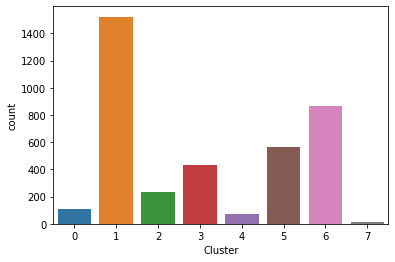

In [55]:
# Print the Cluster Centers
print("Features", "\tPrice", "\tFees", "\tAccom.", "\tWCs", "\tRooms", "\tBeds")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(temp_clustering)

# Append Labels to the Data
X_labeled = temp_clustering.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])

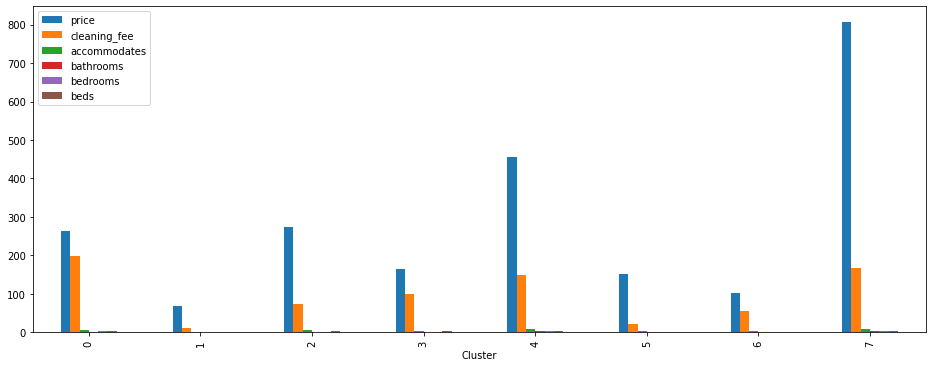

In [56]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(X_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))

In [57]:
clustering_data = pd.concat([ids, X_labeled.reindex(index = ids.index)], axis = 1, sort = False)
clustering_data

,id,price,cleaning_fee,accommodates,bathrooms,bedrooms,beds,Cluster
0,241032,85.0,0.0,4,1.0,1.0,1.0,1
1,953595,150.0,40.0,4,1.0,1.0,1.0,5
2,3308979,975.0,300.0,11,4.5,5.0,7.0,7
3,7421966,100.0,0.0,3,1.0,0.0,2.0,1
4,278830,450.0,125.0,6,2.0,3.0,3.0,4
...,...,...,...,...,...,...,...,...
3813,8101950,359.0,230.0,6,2.0,3.0,3.0,0
3814,8902327,79.0,50.0,4,1.0,1.0,2.0,6
3815,10267360,93.0,35.0,2,1.0,1.0,1.0,6
3816,9604740,99.0,45.0,2,1.0,0.0,1.0,6


In [58]:
reviews_data = pd.read_csv("https://raw.githubusercontent.com/brandonywl/cz1015-miniproject/master/reviews.csv", \
                      usecols = ["listing_id", "comments"])
clusternum = 1

subset = pd.DataFrame(clustering_data[clustering_data['Cluster'] == clusternum])
subset_id = subset['id']

reviews = reviews_data[reviews_data.listing_id.isin(subset_id)]
reviews

,listing_id,comments
0,7202016,Cute and cozy place. Perfect location to every...
1,7202016,Kelly has a great room in a very central locat...
2,7202016,"Very spacious apartment, and in a great neighb..."
3,7202016,Close to Seattle Center and all it has to offe...
4,7202016,Kelly was a great host and very accommodating ...
...,...,...
84825,3424991,Had a great stay. Michael and Leah made it re...
84826,3424991,We had a good stay at Michael. He and Leah pro...
84827,3424991,"In big city, it is very hard to find a clean r..."
84828,1179538,I was searching for a place last minute for my...


# Using NLP to 

In [59]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [60]:
reviews['comments'] = reviews['comments'].astype("str")
reviews['comments'].fillna('Null', inplace = True)
reviews['comments'] = reviews['comments'].str.replace(r'[^\x00-\x7F]+', '')

temp_comments = reviews['comments']
temp_comments = " ".join(temp_comments)
tokens = word_tokenize(temp_comments)
clean_tokens = []
stop_words = stopwords.words('english')

new_stop = ['place', 'stay', 'house', 'highly', 'recommend', 'nice', 'everything', 'needed', '\'s', 'n\'t', 'great', \
            'seattle', 'us', 'host', 'would', 'time', 'apartment', 'easy', 'definitely', 'really', 'also', 'well', \
            'amazing', 'room', 'home', 'made', 'get', 'like', 'even', 'good', 'wonderful', ' could']
new_stop += stop_words
new_stop += list(string.punctuation)

for w in tokens:
    if w.lower() not in new_stop:
        clean_tokens.append(w)

C:\Users\Brandon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Brandon\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Brandon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

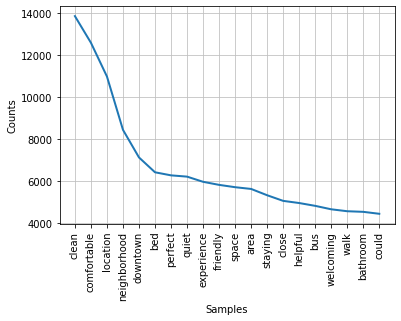

In [61]:
freq = nltk.FreqDist(clean_tokens)
freq.plot(20, cumulative = False)

In [62]:
top_words = [word[0] for word in freq.most_common(19)]
top_words

['clean',
 'comfortable',
 'location',
 'neighborhood',
 'downtown',
 'bed',
 'perfect',
 'quiet',
 'experience',
 'friendly',
 'space',
 'area',
 'staying',
 'close',
 'helpful',
 'bus',
 'welcoming',
 'walk',
 'bathroom']

In [63]:
'''
Given a user's inputs, recommend a price for the listing using regression.
Afterwards, using the price selected & the inputs, predict the cluster of the input.
Using that cluster, show the top 19 words that people say about the listings in that cluster to recommend points to work on
'''

price	neighbourhood_group_cleansed	property_type	room_type	security_deposit	cleaning_fee	accommodates	bathrooms	bedrooms	beds

neighbourhood_group = 
property_type = 
room_type = 
security_deposit = 
cleaning_fee =
accommodates = 
bathrooms = 
bedrooms = 
beds = 

pred_price = xg_reg.predict()
# can have different input price if estimated is not taken up
label = kmeans.predict()
df['Cluster'] = pd.Categorical(label)




SyntaxError: invalid syntax (<ipython-input-63-e21ad91360f6>, line 7)

# Conclusion

# Reference


https://towardsdatascience.com/predicting-airbnb-prices-with-machine-learning-and-deep-learning-f46d44afb8a6
<br >https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
<br> https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb
<br> https://medium.com/@lily_su/adjusting-parameters-for-scikitlearn-use-case-of-predicting-daily-total-number-of-bicycle-trips-c6cfdec02993